In [146]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from scipy.optimize import brentq

In [147]:
plt.rcParams["figure.figsize"] = (14,4)

#### Quantizer function 

In [148]:
class quantizer:
    # implements a uniform deadzone quantizer with M levels over the [-A, A] interval
    def __init__(self, M, A=1):
        assert M % 2 == 1, "only considering mid-thread quantizers"
        self.clip = A
        self.offset = (M - 1) // 2
        self.step = 2 * A / M 
        
    def qbin(self, x):
        # return the INDEX of the quantization bin, i.e. an integer in the range [0, M-1]
        if np.max(np.abs(x)) > self.clip:
            raise OverflowError
        return (np.floor(x / self.step + 0.5) + self.offset).astype(int)
    
    def qvalue(self, i):
        # quantization value for bin i
        return self.step * (i - self.offset)
    
    def quantize(self, x):
        # return the quantized value
        return self.qvalue(self.qbin(x))
    
    def qthreshold(self, ix, iy):
        # return the midpoint between quantization bins ix and iy
        assert abs(ix - iy) == 1, "trying to obtain the threshold across more than 2 quantization levels"
        ix = ix + (0.5 if iy > ix else -0.5)
        return (ix - self.offset) * self.step
    
    def step(self):
        return self.step

In [149]:
'''
def test_func(x):
    f0 = 1.2 # Hz
    return 0.9 * np.cos(2 * np.pi * f0 * x) 
    '''
def test_func(x):
    f0 = 1.2 # Hz
    return 0.9 * np.sin(2 * np.pi * f0 * x) 

-0.2


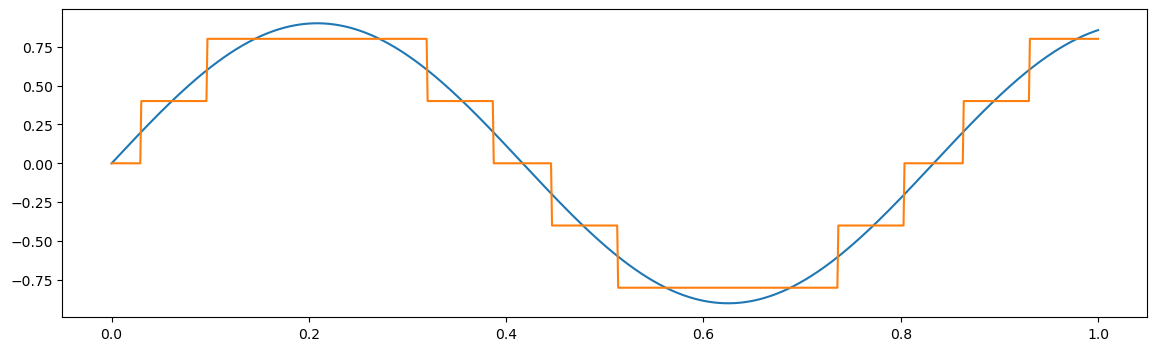

In [150]:
q = quantizer(5)
step = q.step

print(q.qthreshold(1,2))

n_range = np.linspace(0, 1, 1000)
plt.plot(n_range, test_func(n_range))
plt.plot(n_range, q.quantize(test_func(n_range)));

#### Amplitude sampler function

In [151]:
def amplitude_sampler(f, T, Q, gd=1000):
    # f : input function
    # T : function period
    # Q : quantizer
    # gd : points per period in initial sampling grid
    
    def shifted_f(x, offset):
        # wrapper to shift the input function 
        return f(x) - offset
    
    transitions, bins = [0], [Q.qbin(f(0))]   # transition times and associated quantization bin
    num_samples = T * gd                      # start with a regular sampling to estimate transition points
    
    for n in range(1, num_samples):
        t = n * T / num_samples
        i = Q.qbin(f(t))
        if i != bins[-1]:
            # a level transition has occurred. Find the exact time
            #  first determine the value for the amplitude crossing
            threshold = Q.qthreshold(bins[-1], i)
            #  then determine the exact crossing time between neighboring samples
            transitions.append(brentq(shifted_f, (n - 1) * T / num_samples, t, args=threshold))
            bins.append(i)
    return np.array(transitions), np.array(bins)

Transition instants: [0.         0.02972127 0.09678314 0.31988353 0.3869454  0.44638794
 0.5134498  0.7365502  0.80361206 0.8630546  0.93011647]
Bins index: [2 3 4 3 2 1 0 1 2 3 4]


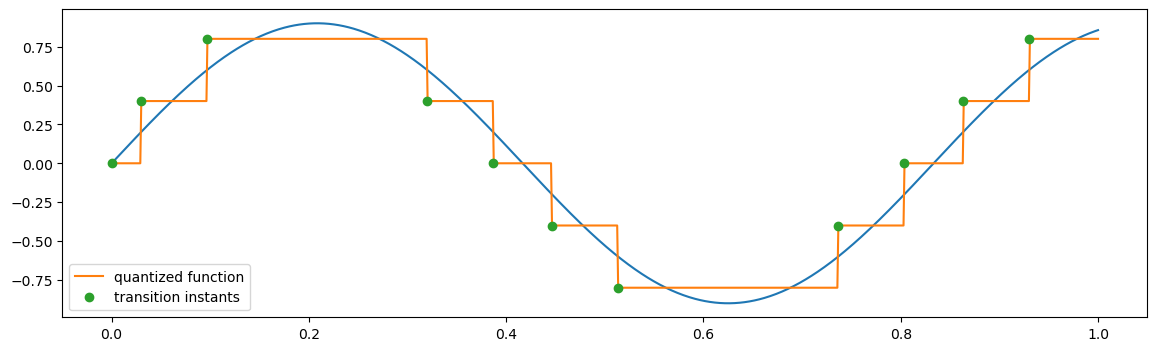

In [152]:
T = 1
n_range = np.linspace(0, T, 1000)

# transitions and bins
t, q_idx = amplitude_sampler(test_func, T, q)

print('Transition instants: {}'.format(t))
print('Bins index: {}'.format(q_idx))

# bins to quantization values
a = q.qvalue(q_idx)  #--> find the step y value for each bin 

plt.plot(n_range, test_func(n_range));
plt.plot(n_range, q.quantize(test_func(n_range)), label='quantized function')
plt.plot(t, a, 'o', label='transition instants')
plt.legend()

The following tests show that the transition points are independent of the density of the initial sampling grid

In [153]:
amplitude_sampler(test_func, T, q, gd=10000)[0]

array([0.        , 0.02972127, 0.09678314, 0.31988353, 0.3869454 ,
       0.44638794, 0.5134498 , 0.7365502 , 0.80361206, 0.8630546 ,
       0.93011647])

In [154]:
amplitude_sampler(test_func, T, q, gd=1000)[0]

array([0.        , 0.02972127, 0.09678314, 0.31988353, 0.3869454 ,
       0.44638794, 0.5134498 , 0.7365502 , 0.80361206, 0.8630546 ,
       0.93011647])

In [155]:
amplitude_sampler(test_func, T, q, gd=100)[0]

array([0.        , 0.02972127, 0.09678314, 0.31988353, 0.3869454 ,
       0.44638794, 0.5134498 , 0.7365502 , 0.80361206, 0.8630546 ,
       0.93011647])

Of course, if the sampling grid is too sparse, then we may jump across multiple quantization levels and so the approach fails


In [156]:
try:
    amplitude_sampler(test_func, T, q, gd=10)[0]
except AssertionError:
    print('crossing more than one level')

crossing more than one level


Now decompose the piecewise-constant signal into the sum of individual pulses. Each pulse is defined by a start and stop time

In [157]:
def decompose(t, i, T):
    assert t[0] == 0, 'first transition should be at t=0'
    M = np.max(i)
    pulses = []
    
    for m in range(1, np.max(i)+1):
        t_start = t[0]
        on = (i[0] >= m)    #--> i[0] is the first bin index (in the previous case it's the highest)
        
        for n in range(1, len(i)):
            if on and i[n] < m:
                on = False
                pulses.append((t_start, t[n]))
            elif not on and i[n] == m:
                on = True
                t_start = t[n]
        if on:
            pulses.append((t_start, T))
    return pulses

In [158]:
decompose(t, q_idx, T)

[(0.0, 0.5134498029994875),
 (0.7365501970005125, 1),
 (0.0, 0.446387936127093),
 (0.8036120638729071, 1),
 (0.029721269460048418, 0.3869453972062404),
 (0.8630546027937596, 1),
 (0.09678313633282086, 0.31988353033384587),
 (0.9301164696661542, 1)]

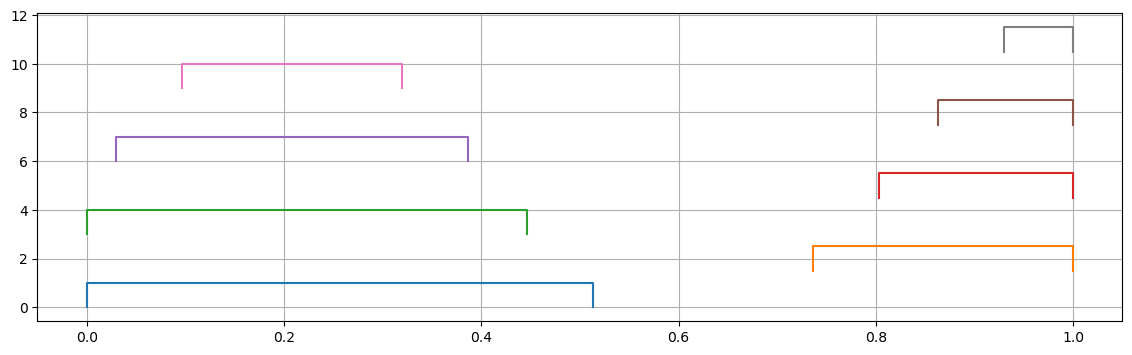

In [159]:
n = 0

for p in decompose(t, q_idx, T):
    plt.plot([p[0], p[0], p[1], p[1]], [n, n+1, n+1, n])
    n += 1.5
plt.grid()
plt.show()

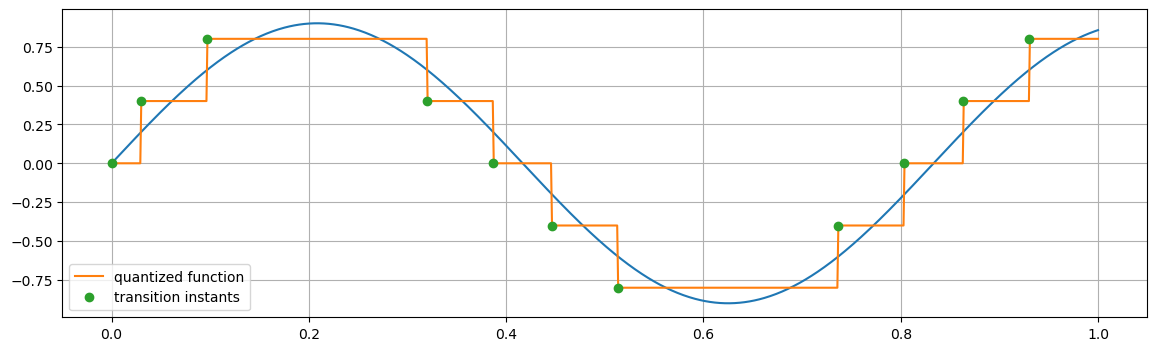

In [160]:
plt.plot(n_range, test_func(n_range));
plt.plot(n_range, q.quantize(test_func(n_range)), label='quantized function')
plt.plot(t, a, 'o', label='transition instants')
plt.grid()
plt.legend()

Let's reconstruct the piecewise amplitude-sampled signal over a discrete grid

In [161]:
def plot_decomposition(pulses, Q, points=1000):
    T = max(list(sum(pulses, ())))
    x = np.zeros(points)
    for p in pulses:
        n = np.round((points / T) * np.array(p)).astype(int)
        x[n[0]:n[1]] += 1
    plt.plot(np.linspace(0, T, points), Q.qvalue(x))

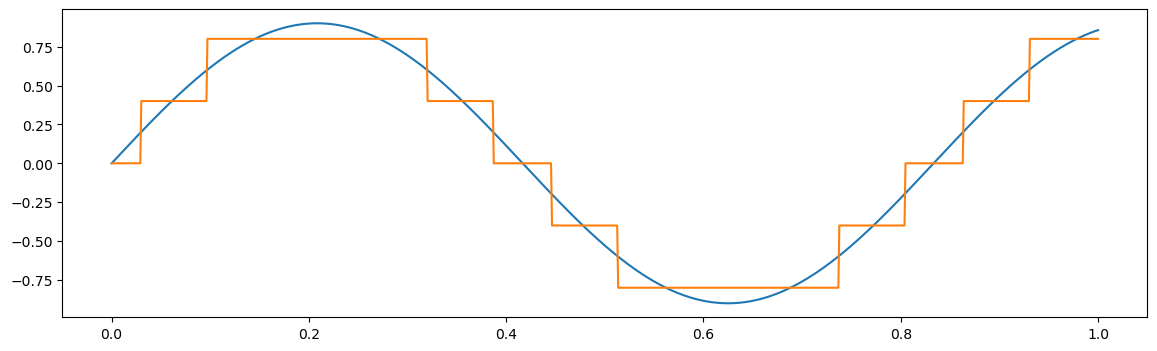

In [162]:
n_range = np.linspace(0, T, 1000)

plt.plot(n_range, test_func(n_range));
plot_decomposition(decompose(t, q_idx, T), q)

#### Analytical Fourier series  

$ \Large{ c_n = \frac{1}{\pi n} e^{-j 2 \pi n \frac{t}{T} \frac{t_{0} + t_{1}}{2} } sin  \left( 2 \pi n \frac{t}{T} \frac{t_{1} - t_{0}}{2}  \right) }$

$ \large{  f ( x ) =  \sum_n c_{n} e^{j 2 \pi n \frac{t}{T} x }  }$

In [163]:
def FS(n, t0,t1, T, xn, delta): 
    F=0
    for i in range(0,n):
        c = 1/n * (np.exp(-1j*2*np.pi*n/T*(t0+t1)/2)*np.sin(2*np.pi*n/T*(t1-t0)/2))
        F_tmp  = delta * c*np.exp(1j*2*np.pi*n*x/T)
        F = F + F_tmp
    return F

(0.0, 0.021)

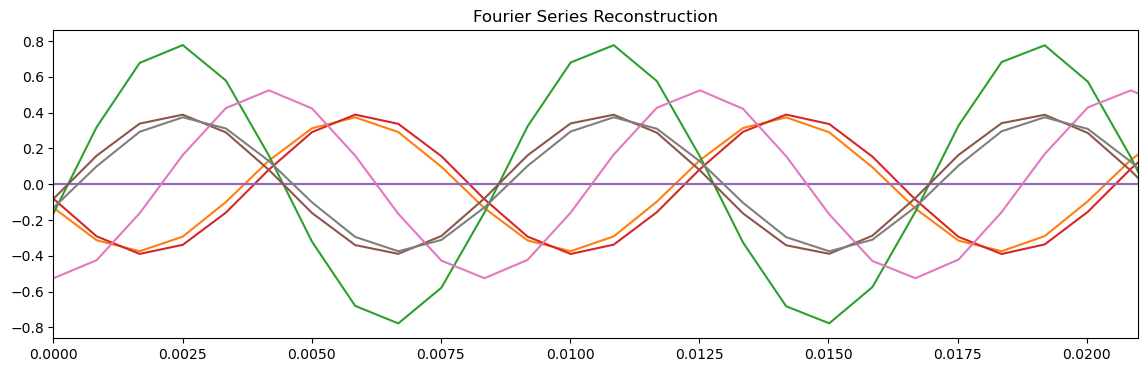

In [201]:
pulse_times= decompose(t, q_idx, T)
x = np.linspace(0, T, 1000)

xf = np.zeros((len(pulse_times), len(x)), dtype=complex)

for i in range(len(pulse_times)):
    xf[i, :] = FS(100, pulse_times[i][0], pulse_times[i][1], T, x, a[i])

xf_tot = np.sum(xf, axis=0)

plt.figure(figsize=(14,4)) 
for i in range(0,len(xf[:,1])):

    plt.plot(x, xf[i,:], label= 'pulse {}'.format(i))
    
plt.title('Fourier Series Reconstruction')
plt.xlim(0, 0.021)



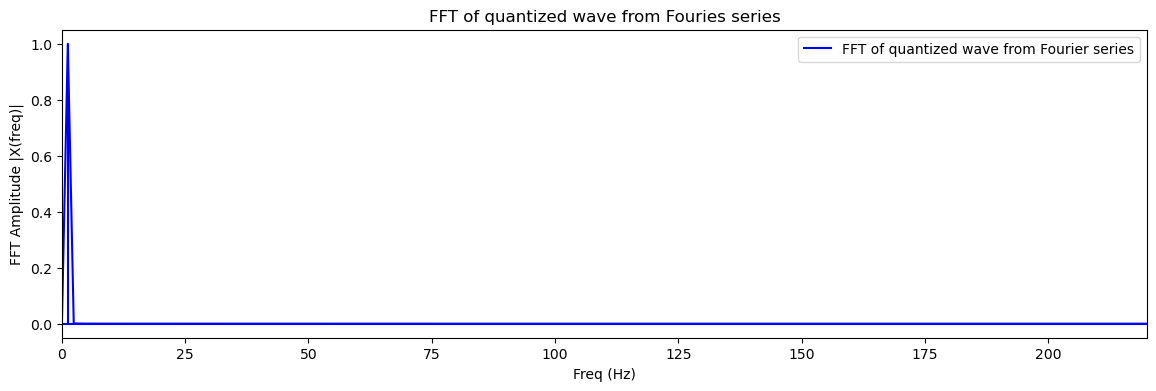

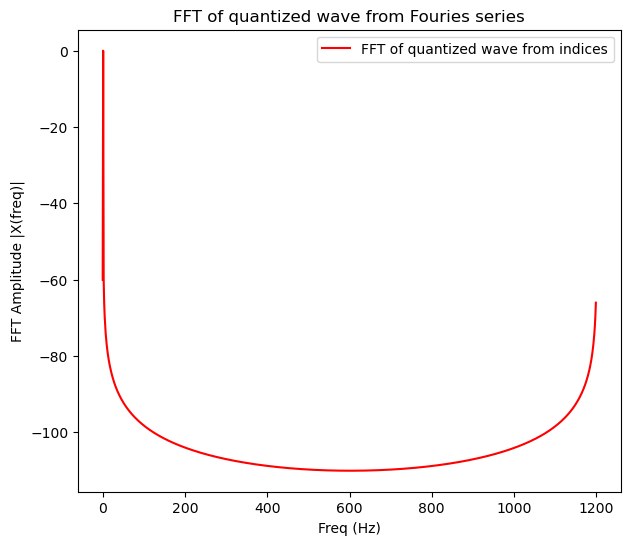

In [165]:

Xf = np.fft.fft(xf_tot)
Xf/= np.abs(Xf).max()


#Frequency vector sampled + quantized wave
N = len(Xf)
n = np.arange(N)
T = N/1200
freq = n/T

plt.stem(freq, np.abs(Xf), 'b', markerfmt=" ", basefmt="-b")
plt.plot(freq, np.abs(Xf), 'b',label='FFT of quantized wave from Fourier series')
plt.xlabel('Freq (Hz)')
plt.legend()
plt.ylabel('FFT Amplitude |X(freq)|')
plt.title('FFT of quantized wave from Fouries series')
plt.xlim(0,220)
plt.show()


plt.figure(figsize=(7,6))
plt.plot(freq, 20*np.log10(np.abs(Xf)), 'r', label='FFT of quantized wave from indices')
plt.xlabel('Freq (Hz)')
plt.legend()
plt.ylabel('FFT Amplitude |X(freq)|')
plt.title('FFT of quantized wave from Fouries series')
plt.show()


